In [1]:


from rosa import AnnDataModule, SingleEmbedding2ExpressionModel
import numpy as np
from glob import glob
import hydra


BASE_PT = '/Users/nsofroniew/Documents/data/multiomics/enformer'
TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT = '/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_with_embeds_new_norm.h5ad'
CHKP_PT_BASE = 'Embedding2ExpressionModel_norm'
CHKP_PT_V = 164
CHKP_PT_F = 1

# CHKP_PT = None
RANK = 16
HEAD = 'Linear'

dm = AnnDataModule(TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT, var_embedding='embedding', batch_size=2**10)
dm.setup()

checkpoint_pt = f"{BASE_PT}/{CHKP_PT_BASE}/lightning_logs/version_{CHKP_PT_V}/checkpoints/*.ckpt"
checkpoint_files = glob(checkpoint_pt)
lm = SingleEmbedding2ExpressionModel.load_from_checkpoint(checkpoint_files[CHKP_PT_F], in_dim=dm.len_var_embedding, out_dim=dm.n_obs, head=HEAD)
adata = dm.predict_dataset.adata

lm

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


SingleEmbedding2ExpressionModel(
  (model): SingleHead(
    (fc): Linear(in_features=3072, out_features=177, bias=True)
  )
)

In [2]:
# model.model.library_size

In [3]:
from pytorch_lightning import Trainer
import torch

trainer = Trainer()
predictions = trainer.predict(lm, dm)
adata.layers['prediction'] = dm.predict_dataset.postprocess(predictions)
# adata.layers['prediction'] = torch.concat(predictions).numpy().T
# adata.layers['prediction_binned'] = np.clip((128 * torch.concat(predictions).numpy().T), 0, 127).astype(int)
# adata.layers['prediction_binned'] = (torch.concat(predictions).numpy().T).astype(int)

# from rosa.preprocessing  import reconstruct_expression

# reconstruct_expression(adata, input_layer='prediction_binned', output_layer='prediction')

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: /Users/nsofroniew/Documents/GitHub/rosa/notebooks/lightning_logs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [4]:
predictions[1].shape

torch.Size([1024, 177])

In [5]:
# adata.layers['prediction_binned'].max()

In [6]:
from rosa.score import score_predictions
from rosa.plotting import plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)


        mean spearmanr across genes 0.633
        mean spearmanr across cells 0.350
        mean square error 0.643
        ks-statistic on total expression 0.271
        mean percent total expression captured per cell 35.783
        


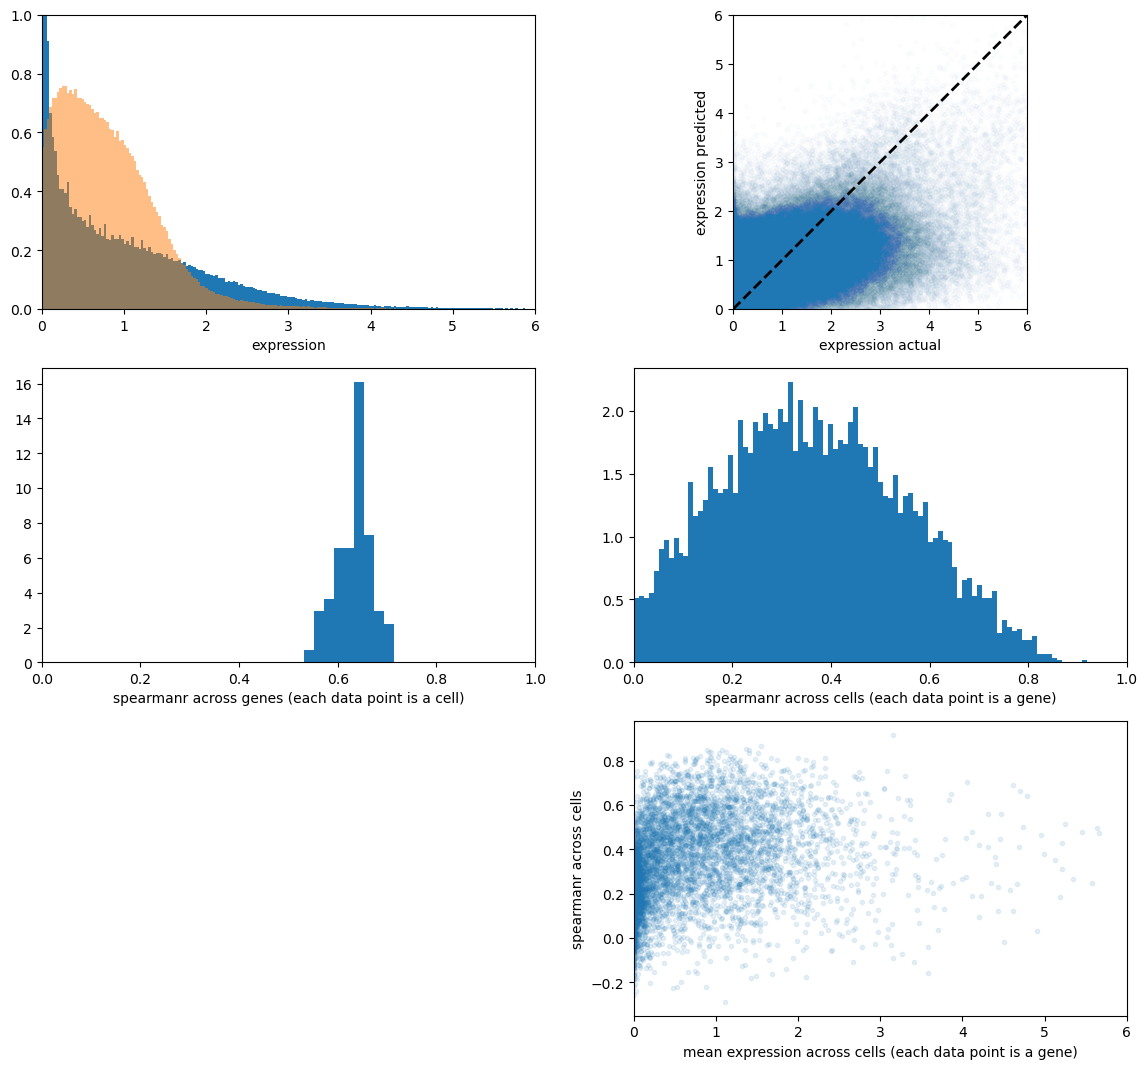

In [7]:
plot_expression_and_correlation(adata_test, results)

In [8]:
# import matplotlib.pyplot as plt

# plt.hist(adata.layers['binned'].flatten(), bins=25, density=True);
# plt.hist(adata.layers['prediction_binned'].flatten(), bins=25, density=True, alpha=0.5);

KeyError: 'binned'

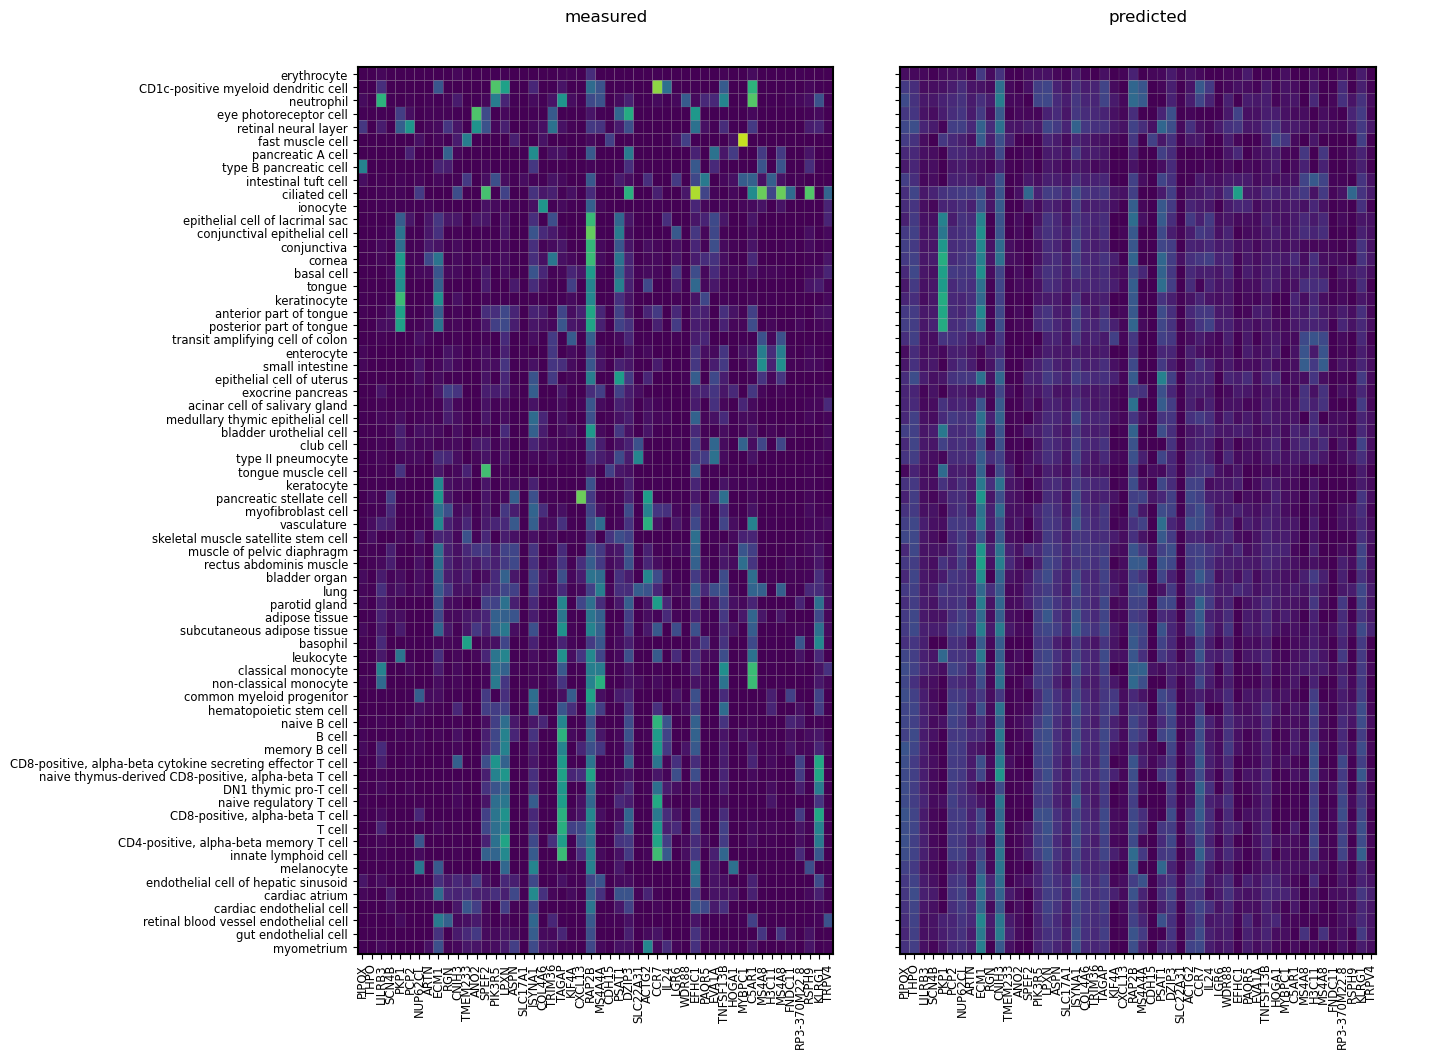

In [9]:
marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

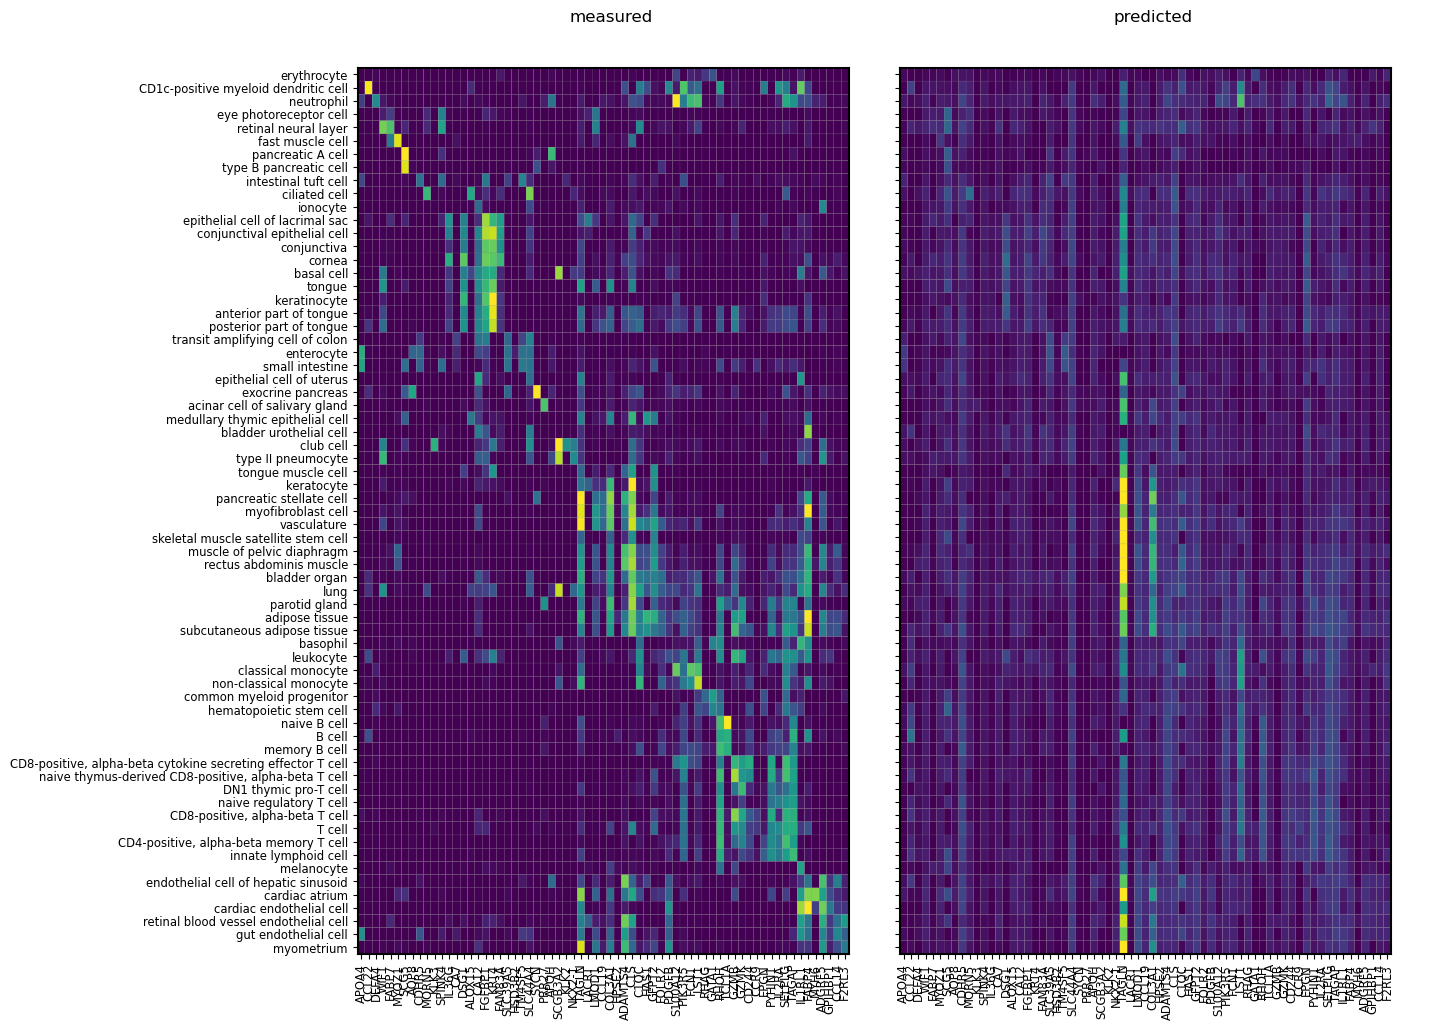

In [10]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)